In [1]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
#data
L= 0.3 # module length in meters
n_f = 6 #number of fibers
i_d = 1.27e-3#internal diameter m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
gamma_w = 32400#shear rate s-1
phi_m = 0.64
eta_0 = 0.001#Pa.second viscosity of hte TGM
rho_p = 1300 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant

# Particle sizes (in meters)
particles = [
    {'name': '4nm', 'radius': 4e-9, 'phi_b': 0.005},
    {'name': '40nm', 'radius': 40e-9, 'phi_b': 0.008},
    {'name': '70nm', 'radius': 70e-9, 'phi_b': 0.021},
    {'name': '120nm', 'radius': 120e-9, 'phi_b': 0.018},
    {'name': '190nm', 'radius': 190e-9, 'phi_b': 0.01},
    {'name': '320nm', 'radius': 320e-9, 'phi_b': 0.008},
    {'name': '700nm', 'radius': 700e-9, 'phi_b': 0.014},
    #  {'name': '2500nm', 'radius': 2500e-9, 'phi_b': 0.007},
]
 #guess for the volume fraction of solute at the membrane wall
phi_w_guess = [0.64] * len(particles)
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 4e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    if phi_b<0.1:
        eta_phi = eta_0*(1+5/2*phi_b)
    elif phi_b>=0.1:
        eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
# print(eta_f)    

eta_f = viscosity_no_PP(eta_0,sum(particles['phi_b'] for particles in particles),10)
diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * target_species)


#k1 around 10 for spheres
#not sure about the shape factor

def max_agg_packing (phi_m):
    phi_Max=phi_m+phi_m*(1-phi_m)+0.74*(1- (phi_m+ phi_m*(1-phi_m)))
    return phi_Max
phi_M = max_agg_packing(phi_m)


#step 3 - maximum back-transport velocity, u (m/s)- Brownian, shear-infuced and intertial lift - Full retention of all solutes
 #particle volume franction at the membrane wall for each particle size for the first iteration
#J_flux = 30 #LMH


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    if phi_w >phi_b:
         J = 0.114 * term * math.log(phi_w / phi_b)
    else:
        J=0
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    if phi_w >phi_b:
        J = 0.078 * term * gamma_w * abs(math.log(phi_w / phi_b))
    else:
        J=0
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)


set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])

def min_flux(Particles, phi_w_list):
    """ have to put particles list with radius and phi_b,
    phi_w_list with phi_w
    results ai_target, J_flux and dataframe"""
    
    min_velocity = float('inf')
    selected_particle_radius = None
    velocities_list=[]

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        # Store all velocities in the DataFrame
        velocities_list.append({
            'name': particle['name'],
            'radius': a,
            'brownian_velocity': brownian_velocity,
            'shear_velocity': shear_velocity,
            'inertial_velocity': inertial_velocity
        })
        velocities_df=pd.DataFrame(velocities_list)
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data,velocities_df

# Initialize variables for particles and inertial-lift properties
# ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            
            # Use the source to choose the max_velocity
            if source == 'inertial':
                max_velocity = J_inertial(a_particle)
            elif source == 'shear':
                max_velocity = J_shear(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            elif source == 'brownian':
                max_velocity = J_brownian(a_particle, phi_w_dict.get(a_particle, 0.64), phi_b_particle)
            else:
                raise ValueError(f"Unknown source {source} for particle {a_particle}")

            if max_velocity >= 10 * min_velocity and source == 'inertial':
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
            elif source == "inertial":
                count += 1
            elif source =="brownian" or source =="shear":
                # Define the objective function based on the source
                def objective_function(phi_w_particle):
                    # Recalculate velocities based on the current wall concentration phi_w_particle
                    if source == 'brownian':
                        max_velocity = J_brownian(a_particle, phi_w_particle, phi_b_particle)
                    elif source == 'shear':
                        max_velocity = J_shear(a_particle, phi_w_particle, phi_b_particle)
                    # elif source == 'inertial':
                    #     max_velocity = J_inertial(a_particle)
                    return abs(max_velocity - min_velocity)

                # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal
                    phi_w_J_dict[a_particle] = phi_w_optimal
                else:
                    print(f"Optimization failed for particle radius {a_particle:.1e} m")
    
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            if phi_w_J_dict[a]!=0:
                phi_wjI = phi_M - sum(phi_w_J_dict.values())
                phi_wjI_dict[a] = phi_wjI
                phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf,vel= min_flux(Particles, phi_w_list)
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000

    while ((phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.64) and phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smallest_int<0.74 and phi_w_updated[min(phi_w_updated.keys())]<0.64)==False:
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != min(phi_w_updated.keys())}
   
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.64) and phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smallest_int<0.74 and phi_w_updated[min(phi_w_updated.keys())]<0.64:
            # print(f"Iteration {i}: Packing constraints are met.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
        
        # Store the previous values of phi_w for comparison
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_updated_list = list(phi_w_updated.values())
        #print(phi_w_updated, J_flux, a_target)
        # Recalculate the flux and phi_w_j values after updating
        ai_target, min_vel, dataf,vel= min_flux(particles, phi_w_updated_list)
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)
        phi_smallest_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_updated[min(phi_w_updated.keys())]))
#        
#       # #step - 9 - calculate the minimum
        r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
        
        # Check for the change in phi_w values between iterations
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        # if phi_w_diff < tolerance:
        #     print(f"Iteration {i}: Will not converger further.")
        #     return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
    # If the loop completes without finding a solution
    print("Warning: No solution found within the iteration limit.")
  
    return phi_w_updated, min_vel, ai_target, dataf,r_minimum, phi_smallest_int

#mass-transfer coefficient calculated from equation  1#step 10


def sieving_parameters(Particles, phi_w_list):
    phi_w_updated, J_flux, ai_target, dataf, r_min, phi_smal_int = packing_constraints(Particles, phi_w_list)
    print(f"Updated phi_w_dict: {phi_w_updated}. J_flux: {J_flux}", f"ai_target: {ai_target}")
    print(dataf)
    print(f"phi_smallest_int: {phi_smal_int:.6f}")
    print(f"Minimum transmission gap {min(phi_w_updated.keys())}: {r_min} m")
    # for i in range(50):
    Q=J_flux *n_f*math.pi*i_d*(L+L/20)
    mass_transfer_k = 1.62 * (diffusion_coeff/i_d)*(((4*rho_f*Q)/(math.pi*n_f*i_d*eta_f))**(1/3))*((eta_f/(rho_f*diffusion_coeff))**(1/3))
    # print(f"mass transfer coefficient: {mass_transfer_k}")
    lambda_s_min = target_species / r_min
    # print(f"lambda_s_min: {lambda_s_min}")
    Sieving_coeff_int = ((1 - lambda_s_min) ** 2) * (2 - ((1 - lambda_s_min) ** 2)) * math.exp(-0.7146 * (lambda_s_min ** 2))
    # print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
    delta_m = target_species * ((4 * (4 / 3) * math.pi) / phi_smal_int) ** (1 / 3)
    # print(f"delta_m: {delta_m}")
    phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
    # print(f"phi_e_K_d: {phi_e_K_d}")
    cake_membrane_porosity = 1 - phi_smal_int
    # print  (f"cake_membrane_porosity: {cake_membrane_porosity}")
    Peclet_m = ((J_flux * delta_m) / diffusion_coeff) * (Sieving_coeff_int / (cake_membrane_porosity * phi_e_K_d))
    if Peclet_m >709 :
       Peclet_m = 709
    # print  (f"Peclet_m: {Peclet_m}")
    Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
    #
    Sieving_coeff_obs = Sieving_coeff_act / ((1 - Sieving_coeff_act) * math.exp(-J_flux / mass_transfer_k) + Sieving_coeff_act)
    print(f"Sieving coefficient: {Sieving_coeff_obs}")
    yields = 1 - math.exp(-4 * (Sieving_coeff_obs))
    # print(f"Yields: {yields}")
            
    return dataf, phi_w_updated,yields,J_flux 



In [ ]:
sieving_parameters(particles, phi_w_guess)

In [14]:
particles
phi_w_dict

{4e-09: 0.010465160671883607,
 4e-08: 0.24658853108923667,
 7e-08: 0.5734174730889493,
 1.2e-07: 0.09008221928628729,
 1.9e-07: 0.023934380278252877,
 3.2e-07: 0.012367129036999063,
 7e-07: 0.008202259032956278,
 2.5e-06: 0}

In [ ]:
# Create columns for J_pred and phi_w for all particle sizes
particle_sizes = [particle['radius'] for particle in particles]
j_pred_columns = [f'J_pred_{int(size*1e9)}' for size in particle_sizes]
phi_w_columns = [f'phi_w_{int(size*1e9)}' for size in particle_sizes]

# Initialize the DataFrame with the new columns
data_figs_columns = ['shear_rate', 'J_flux', 'yield'] + j_pred_columns + phi_w_columns
data_figs = pd.DataFrame(columns=data_figs_columns)

gamma_w_list = range(20000, 90000, 500)

for i in range(len(gamma_w_list)):
    phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i]  # shear rate s-1
    L = 0.3
    min_flux(particles, phi_w_guess)
    
    # Collect J_pred and phi_w values for all particle sizes
    j_pred_values = [data_F.loc[data_F['radius'] == size, 'max_velocity'].values[0] for size in particle_sizes]
    phi_w_values = [phi_w_dict[size] for size in particle_sizes]
    
    # Combine all values into a single row
    row_values = [gamma_w, J_flux, Yield] + j_pred_values + phi_w_values
    data_figs.loc[i] = row_values

Iteration 334: Will not converger further.
Iteration 38: Will not converger further.
Iteration 34: Will not converger further.
Iteration 40: Will not converger further.
Iteration 47: Will not converger further.
Iteration 42: Will not converger further.
Iteration 26: Will not converger further.
Iteration 65: Will not converger further.
Iteration 51: Will not converger further.
Iteration 61: Will not converger further.
Iteration 35: Will not converger further.
Iteration 51: Will not converger further.
Iteration 43: Will not converger further.
Iteration 29: Will not converger further.
Iteration 4: Will not converger further.
Iteration 17: Will not converger further.
Iteration 33: Will not converger further.
Iteration 6: Will not converger further.
Iteration 18: Will not converger further.
Iteration 49: Will not converger further.
Iteration 22: Will not converger further.
Iteration 72: Will not converger further.
Iteration 16: Will not converger further.
Iteration 4: Will not converger fur

/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 286: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 215: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 24: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 52: Will not converger further.
Iteration 12: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) *

Iteration 7: Will not converger further.
Iteration 24: Will not converger further.
Iteration 36: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 50: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 98: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 15: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 13: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 108: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 11: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 11: Will not converger further.
Iteration 9: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 18: Will not converger further.


/var/folders/bm/sy1kc1hn56j5hgn9wdzg9yhr0000gn/T/ipykernel_49782/1300745903.py:244: RuntimeWarning: invalid value encountered in scalar power
  r_minimum = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2


Iteration 107: Will not converger further.
Iteration 111: Will not converger further.
Iteration 24: Will not converger further.
Iteration 23: Will not converger further.
Iteration 161: Will not converger further.
Iteration 16: Will not converger further.
Iteration 21: Will not converger further.
Iteration 7: Will not converger further.
Iteration 16: Will not converger further.
Iteration 10: Will not converger further.
Iteration 51: Will not converger further.
Iteration 29: Will not converger further.
Iteration 46: Will not converger further.
Iteration 44: Will not converger further.
Iteration 107: Will not converger further.
Iteration 13: Will not converger further.
Iteration 44: Will not converger further.
Iteration 25: Will not converger further.
Iteration 31: Will not converger further.
Iteration 65: Will not converger further.
Iteration 21: Will not converger further.
Iteration 20: Will not converger further.
Iteration 24: Will not converger further.
Iteration 18: Will not converge

ValueError: math domain error

In [3]:
# Create columns for J_pred for all particle sizes
particle_sizes = [particle['radius'] for particle in particles]
j_pred_columns = [f'J_pred_{int(size*1e9)}' for size in particle_sizes]

# Initialize the DataFrame with the new columns
data_figs_2_columns = ['shear_rate'] + j_pred_columns
data_figs_2 = pd.DataFrame(columns=data_figs_2_columns)
gamma_w_list = range(20000, 90000, 500)
for i in range(len(gamma_w_list)):
    phi_w_dict = {key: values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i]  # shear rate s-1

    a_T, min_J, set_datas, vel_df = min_flux(particles, phi_w_guess)
    
    # Collect J_pred values for all particle sizes
    j_pred_values = [set_datas.loc[set_datas['radius'] == size, 'max_velocity'].values[0] for size in particle_sizes]
    
    # Combine all values into a single row
    row_values = [gamma_w] + j_pred_values
    data_figs_2.loc[i] = row_values

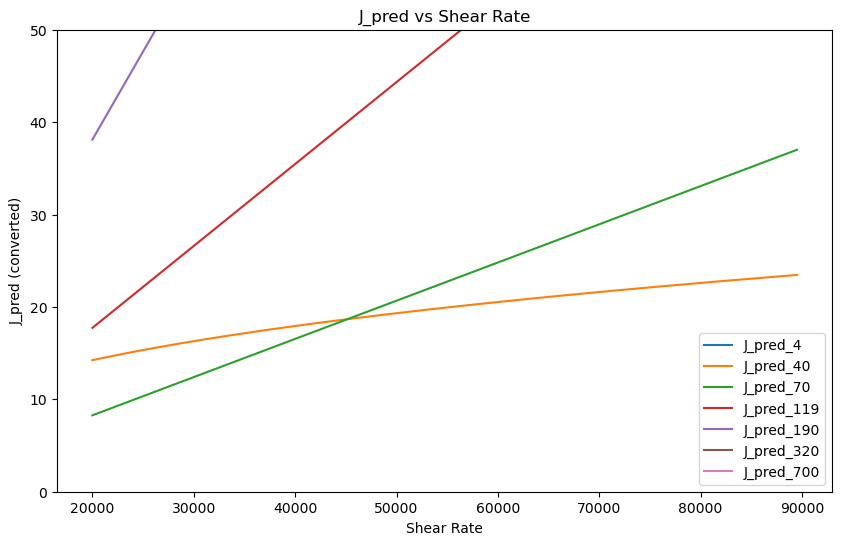

In [9]:
plt.figure(figsize=(10, 6))
for column in j_pred_columns:
    plt.plot(data_figs_2['shear_rate'], data_figs_2[column] * 3600 * 1000, label=column)
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.ylim(0, 50)
plt.show()


In [107]:
phi_M

0.966304